## SENTIMENT CLASSIFICATION USING RoBERTa

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [25]:
pip install transformers

In [26]:
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import seaborn as cns

%matplotlib inline
cns.set(style = "whitegrid", palette = "muted", font_scale = 1.2)

device = "cpu"
if torch.cuda.is_available():             # Check if GPU is available
  device = "cuda"

print(device)

cuda


In [27]:
class IMBD_dataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews                   # List of reviews
    self.targets = targets                   # List of targets
    self.tokenizer = tokenizer               # Tokenizer to be used (BERT)
    self.max_length = max_len                # Maximum length of one sentence

  def __len__(self):
    return len(self.reviews)                  # No of Examples

  def __getitem__(self, index):
    review = str(self.reviews[index])         # Get the review at the particular index
    target = self.targets[index]              # Get the target label at the particular index

    encoding = self.tokenizer.encode_plus(    # Encoder encoding the particular review
        review, 
        add_special_tokens = True,
        max_length = self.max_length,
        return_token_type_ids = False,
        padding = "max_length",
        truncation = True,
        return_attention_mask = True,
        return_tensors = "pt"
    )
    # The class simply returns a dictionary of the following
    
    return {"review_text":str(review),
            "target":torch.tensor(target, dtype = torch.long),
            "encoding":encoding["input_ids"].flatten(),
            "attention_mask":encoding["attention_mask"].flatten()
            }


In [28]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  data = IMBD_dataset(df.review.to_numpy(), 
                      df.sentiment.to_numpy(), 
                      tokenizer = tokenizer, 
                      max_len = max_len
                      )

  return DataLoader(data, batch_size = batch_size, num_workers = 0)


In [29]:
from transformers import RobertaTokenizer, RobertaModel

BATCH_SIZE = 2
MAX_LEN = 512
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

### OPTIMIZER

# ROBERTA

In [7]:
EPOCHS = 5
from torch.optim import AdamW

base_model = RobertaModel.from_pretrained("roberta-base")
optimizer = AdamW(base_model.parameters(), lr = 1e-5)
total_steps = 10000*EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 2, num_training_steps = total_steps)
loss_func = nn.CrossEntropyLoss().to(device)

In [8]:
class Sentimentclassifier(nn.Module):
  def __init__(self, n_classes):
    super(Sentimentclassifier, self).__init__()
    self.roberta = base_model
    self.drop = nn.Dropout(p = 0.3)
    self.layer1 = nn.Linear(self.roberta.config.hidden_size, 64)
    self.drop1 = nn.Dropout(p = 0.1)
    self.layer2 = nn.Linear(64, 64, )
    self.drop2 = nn.Dropout(p = 0.1)
    self.out = nn.Linear(64, n_classes)

  def forward(self, input_ids, attention_mask):
    output = self.roberta(input_ids = input_ids, attention_mask = attention_mask)
    output = self.drop(output[1])
    output = self.layer1(output)
    output = self.drop1(output)
    output = self.layer2(output)
    output = self.drop2(output)
    return self.out(output)


model = Sentimentclassifier(2)
model = model.to(device)

### TRAIN ONE EPOCH

In [9]:
def train_epoch(model, data_loader, loss_func, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0

  total_batches = len(data_loader)
  i = 1

  for d in data_loader:
    input_ids = d["encoding"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["target"].to(device)

    outputs = model(input_ids = input_ids, attention_mask = attention_mask)

    _, preds = torch.max(outputs, dim = 1)
    loss = loss_func(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    if ((i+1)%1000) == 0:
      print("Batch {}/{} Train Loss {:.4f} Train Batch Acc {:.3f}%".format(i+1, total_batches, loss.item(), correct_predictions*100/n_examples))
    i += 1
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double()/n_examples, np.mean(losses)


### EVALUATE MODEL ON VALIDATION SET

In [10]:
def eval_model(model, data_loader, loss_func, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["encoding"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["target"].to(device)

      outputs = model(input_ids = input_ids, attention_mask = attention_mask)
      _, preds = torch.max(outputs, dim = 1)
      loss = loss_func(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

    return correct_predictions.double()/n_examples, np.mean(losses)


## IMPORT TOKENIZERS AND OTHER PACKAGES

In [11]:
from zipfile import ZipFile
from google.colab import drive

drive.mount("/content/drive")
file_path = "drive/MyDrive/IMDB Dataset.csv.zip"
with ZipFile(file_path, "r") as zip:
  zip.extractall()

df = pd.read_csv("IMDB Dataset.csv")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### CLEAN SENTENCES AND LEMMATIZE

In [12]:
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

def remove_stop_words(line):
  review = []
  for word in line.split(' '):
      if word not in stop_words:
        review.append(word)

  line = (" ").join(review)
  return line

def single_sentence(line):
  matches = re.findall("\.", line)
  if (len(matches) > 1):
    return 0
  return 1

def lemmatize(line):
  lemmatized_list = [lemmatizer.lemmatize(w) for w in line.split(' ')]
  lemmatized_sentence = (" ").join(lemmatized_list)
  return lemmatized_sentence

def summarize_sentence(line):
  if len(line) > SENTENCE_LENGTH_THRESHOLD:
    summarized_sentence = summarize(line, word_count = 320)
    return summarized_sentence
  
  return line

def truncate(line):
  review_len = len(line.split(' '))
  if review_len < 500:
    return line
  words = line.split(' ')
  truncated_line = (' ').join(words[:256] + words[-256:])
  return truncated_line

def parse_line(line, LOWER_CASE, REMOVE_STOPWORDS, LEMMATIZE):
    if LOWER_CASE:
      line = line.strip().lower()
    line = line.replace("&nbsp;", " ")
    line = re.sub(r'<br(\s\/)?>', ' ', line)
    line_len = len(line.split(' '))
    if REMOVE_STOPWORDS:
      line = remove_stop_words(line)
    line = truncate(line)
    if LEMMATIZE:
      line = lemmatize(line)
    return line

def clean_dataset(df, LOWER_CASE, REMOVE_STOPWORDS, LEMMATIZE):
  reviews = []
  sentiments = []
  for i in range(len(df.review)):
    if (i+1)%25000 == 0:
      print("Cleaning Sentence ", i+1)
    reviews.append([parse_line(str(df.iloc[i, 0]), LOWER_CASE, REMOVE_STOPWORDS, LEMMATIZE)])
    sentiments.append([df.iloc[i, 1]])

  data = np.concatenate((np.array(reviews), np.array(sentiments)), axis = 1)
  df_clean = pd.DataFrame(data = data, columns = ["review", "sentiment"])
  print(df_clean.head())
  return df_clean



np.unique(df.sentiment, return_counts = True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


(array(['negative', 'positive'], dtype=object), array([25000, 25000]))

### LABEL ENCODING SENTIMENTS

In [13]:
from sklearn.preprocessing import LabelEncoder

def label_encode(df_clean):
  enc = LabelEncoder()
  df_clean.sentiment = enc.fit_transform(df_clean.sentiment)
  df_clean.head()
  return df_clean

### PLOTTING SENTENCE LENGTHS

In [14]:
def plot_seq_len(df_clean):
  seq_len = []
  for sentence in df_clean.review:
    seq_len.append(len(sentence.split(' ')))

  mean = np.mean(seq_len)
  sd = np.std(seq_len)
  print("Mean of Sequence Lengths = ", mean)
  print("Standard Deviation Length = ", sd)
  plt.hist(seq_len, bins = 40)
  plt.show()


## Defining a Class for Storing Dataset

The class stores all the reviews and targets, tokenizer and max length.

Specifying the index returns the review text, target, encoding and attention mask as a dictionary.

### Splitting Dataset into Train and Test Set

In [15]:
def split_data(df_clean):
  df_train, df_temp = train_test_split(df_clean, test_size = 0.2, random_state = 10)
  df_val, df_test = train_test_split(df_temp, test_size = 0.5, random_state = 10)
  return df_train, df_val, df_test

##Creating Data Loaders for batch wise Training

In [16]:
def data_loaders(df_train, df_val, df_test):
  train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
  val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
  test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)
  return train_data_loader, val_data_loader, test_data_loader

In [17]:
def prepare_dataset(df, LOWERCASE, REMOVE_STOPWORDS, LEMMATIZE):
  df_clean = clean_dataset(df, LOWERCASE, REMOVE_STOPWORDS, LEMMATIZE)
  df_clean = label_encode(df_clean)
  plot_seq_len(df_clean)
  df_train, df_val, df_test = split_data(df_clean)
  dl_train, dl_val, dl_test = data_loaders(df_train, df_val, df_test)
  return dl_train, dl_val, dl_test, df_train, df_val, df_test

In [18]:
def fit_and_evaluate(model, train_data_loader, val_data_loader, test_data_loader, loss_func, optimizer, device, scheduler, df_train, df_val, df_test):
  history = {"train_acc":[], "train_loss":[], "val_loss":[], "val_acc":[]}
  best_accuracy = 0

  for epoch in range(EPOCHS):
    print("Epoch {}/{}".format(epoch + 1, EPOCHS))
    print("-"*100)
    train_acc, train_loss = train_epoch(model, train_data_loader, loss_func, optimizer, device, scheduler, len(df_train))    
    print("Train Loss {:.4f} Train Acc {:.2f}".format(train_loss, train_acc*100))
    
    val_acc, val_loss = eval_model(model, val_data_loader, loss_func, device, len(df_val))
    print("Validation Loss {:.4f} Validation Acc {:.2f}".format(val_loss, val_acc*100))

    history["train_acc"].append(train_acc)
    history["train_loss"].append(train_loss)
    history["val_acc"].append(val_acc)
    history["val_loss"].append(val_loss)

    if val_acc > best_accuracy:
      torch.save(model.state_dict(), "best_model_state.bin")
      best_accuracy = val_acc

  print("Final Test Accuracy :\n")
  test_acc,_ = eval_model(model, test_data_loader, loss_func, device, len(df_test))
  print(test_acc)
  return train_acc, val_acc, test_acc

Cleaning Sentence  25000
Cleaning Sentence  50000
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production.   The filming t...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
Mean of Sequence Lengths =  254.04468
Standard Deviation Length =  172.9538439113095


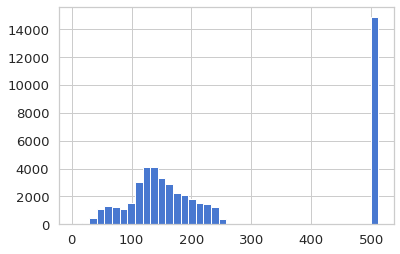

Epoch 0/4
------------------------------------------------------------
Batch 1000/20000 Train Loss 0.0194 Train Batch Acc 4.207%
Batch 2000/20000 Train Loss 2.1865 Train Batch Acc 8.730%
Batch 3000/20000 Train Loss 0.0065 Train Batch Acc 13.295%
Batch 4000/20000 Train Loss 0.0046 Train Batch Acc 17.948%
Batch 5000/20000 Train Loss 0.0042 Train Batch Acc 22.517%
Batch 6000/20000 Train Loss 0.0050 Train Batch Acc 27.147%
Batch 7000/20000 Train Loss 0.0047 Train Batch Acc 31.792%
Batch 8000/20000 Train Loss 0.0044 Train Batch Acc 36.450%
Batch 9000/20000 Train Loss 0.0032 Train Batch Acc 41.125%
Batch 10000/20000 Train Loss 0.0036 Train Batch Acc 45.770%
Batch 11000/20000 Train Loss 0.0031 Train Batch Acc 50.412%
Batch 12000/20000 Train Loss 1.6457 Train Batch Acc 55.050%
Batch 13000/20000 Train Loss 0.0074 Train Batch Acc 59.677%
Batch 14000/20000 Train Loss 0.0028 Train Batch Acc 64.325%
Batch 15000/20000 Train Loss 0.0095 Train Batch Acc 69.000%
Batch 16000/20000 Train Loss 0.0029 Trai

In [19]:
LOWERCASE = 0
REMOVE_STOPWORDS = 0
LEMMATIZE = 0

dl_train, dl_val, dl_test, df_train, df_val, df_test = prepare_dataset(df, LOWERCASE, REMOVE_STOPWORDS, LEMMATIZE)
train_acc, val_acc, test_acc = fit_and_evaluate(model, dl_train, dl_val, dl_test, loss_func, optimizer, device, scheduler, df_train, df_val, df_test)
print("Converted to lowercase = ", bool(LOWERCASE), " StopWords Removed = ", bool(REMOVE_STOPWORDS), " Lemmatized = ", bool(LEMMATIZE))
print("Training Accuracy {:.4f}%, Validation Accuracy {:.4f}%, Test Accuracy {:.4f}%".format(train_acc*100, val_acc*100, test_acc*100))


In [20]:
'''
plt.plot(history["train_loss"], c="r", label = "Train Loss")
plt.plot(history["val_loss"], c="g", label = "Validation Loss")
plt.legend()
plt.show()
plt.plot(history["train_acc"], c="r", label = "Train Accuracy")
plt.plot(history["val_acc"], c="g", label = "Validation Accuracy")
plt.legend()
plt.show()
'''

'\nplt.plot(history["train_loss"], c="r", label = "Train Loss")\nplt.plot(history["val_loss"], c="g", label = "Validation Loss")\nplt.legend()\nplt.show()\nplt.plot(history["train_acc"], c="r", label = "Train Accuracy")\nplt.plot(history["val_acc"], c="g", label = "Validation Accuracy")\nplt.legend()\nplt.show()\n'

Cleaning Sentence  25000
Cleaning Sentence  50000
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production.   The filming t...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
Mean of Sequence Lengths =  254.04468
Standard Deviation Length =  172.9538439113095


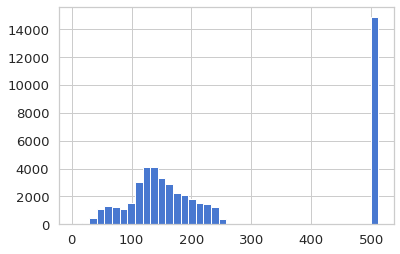

Mean of Sequence Lengths =  231.14594
Standard Deviation Length =  171.3247057534797


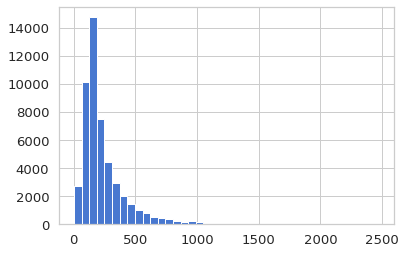

"The Cell" is an exotic masterpiece, a dizzying trip into not only the vast mind of a serial killer, but also into one of a very talented director. This is conclusive evidence of what can be achieved if human beings unleash their uninhibited imaginations. This is boldness at work, pushing aside thoughts to fall into formulas and cliches and creating something truly magnificent. This is the best movie of the year to date.<br /><br />I've read numerous complaints about this film, anywhere from all style and no substance to poorly cast characters and bad acting. To negatively criticize this film is to miss the point. This movie may be a landmark, a tradition where future movies will hopefully follow. "The Cell" has just opened the door to another world of imagination. So can we slam the door in its face and tell it and its director Tarsem Singh that we don't want any more? Personally, I would more than welcome another movie by Tarsem, and would love to see someone try to challenge him.<br

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [21]:
df_clean = clean_dataset(df, 0, 0, 0)
plot_seq_len(df_clean)
plot_seq_len(df)

for review in df.review:
  n_words = review.split(' ')
  if len(n_words) > 401:
    print(review)
    print(len(n_words))


In [22]:
del model

In [23]:
i = 0
for review in df.review:
  if len(review.split(' ')) < 300:
    continue
  i += 1
  print(review)
  if i>5:
    break

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fac